# AddRNN

# Train-Test 7:3

## Crude Oil - 7:3

Epoch 1/20
42/42 [==============================] - 2s 6ms/step - loss: 0.0292
Epoch 2/20
42/42 [==============================] - 0s 6ms/step - loss: 7.9136e-04
Epoch 3/20
42/42 [==============================] - 0s 6ms/step - loss: 5.6784e-04
Epoch 4/20
42/42 [==============================] - 0s 6ms/step - loss: 4.8191e-04
Epoch 5/20
42/42 [==============================] - 1s 25ms/step - loss: 3.7470e-04
Epoch 6/20
42/42 [==============================] - 1s 16ms/step - loss: 3.4805e-04
Epoch 7/20
42/42 [==============================] - 0s 4ms/step - loss: 3.3738e-04
Epoch 8/20
42/42 [==============================] - 0s 4ms/step - loss: 3.3179e-04
Epoch 9/20
42/42 [==============================] - 0s 6ms/step - loss: 3.1530e-04
Epoch 10/20
42/42 [==============================] - 0s 5ms/step - loss: 3.1948e-04
Epoch 11/20
42/42 [==============================] - 0s 5ms/step - loss: 3.0849e-04
Epoch 12/20
42/42 [==============================] - 0s 5ms/step - loss: 3.1141e-04
Epo

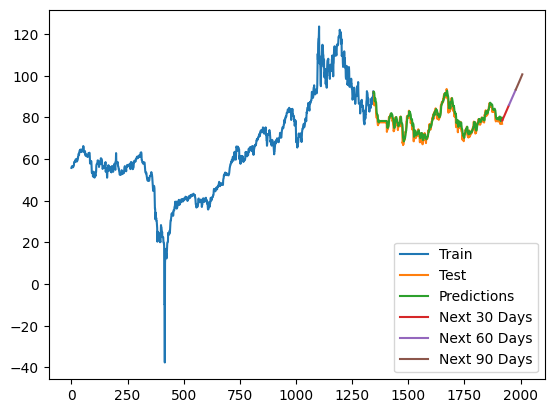

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil WTI.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Gasoline RBOB - 7:3

Epoch 1/20
42/42 [==============================] - 1s 4ms/step - loss: 0.0263
Epoch 2/20
42/42 [==============================] - 0s 4ms/step - loss: 5.2874e-04
Epoch 3/20
42/42 [==============================] - 0s 4ms/step - loss: 4.2430e-04
Epoch 4/20
42/42 [==============================] - 0s 4ms/step - loss: 3.9824e-04
Epoch 5/20
42/42 [==============================] - 0s 4ms/step - loss: 3.8924e-04
Epoch 6/20
42/42 [==============================] - 0s 4ms/step - loss: 3.8930e-04
Epoch 7/20
42/42 [==============================] - 0s 6ms/step - loss: 3.6477e-04
Epoch 8/20
42/42 [==============================] - 0s 6ms/step - loss: 3.9400e-04
Epoch 9/20
42/42 [==============================] - 0s 4ms/step - loss: 3.7732e-04
Epoch 10/20
42/42 [==============================] - 0s 5ms/step - loss: 3.8108e-04
Epoch 11/20
42/42 [==============================] - 0s 4ms/step - loss: 3.4278e-04
Epoch 12/20
42/42 [==============================] - 0s 5ms/step - loss: 3.7348e-04
Epoch

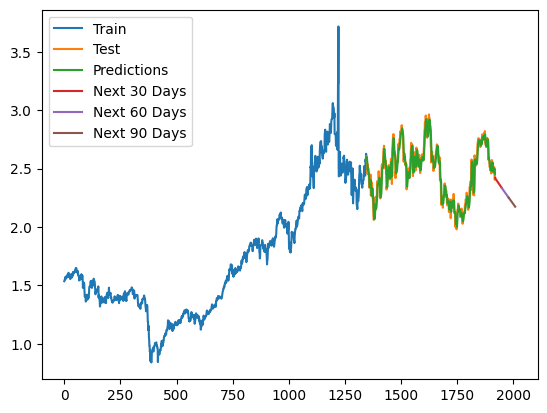

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Heating Oil - 7:3

Epoch 1/20
42/42 [==============================] - 2s 3ms/step - loss: 0.0450
Epoch 2/20
42/42 [==============================] - 0s 4ms/step - loss: 6.3955e-04
Epoch 3/20
42/42 [==============================] - 0s 4ms/step - loss: 4.7045e-04
Epoch 4/20
42/42 [==============================] - 0s 4ms/step - loss: 3.6632e-04
Epoch 5/20
42/42 [==============================] - 0s 4ms/step - loss: 3.5536e-04
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 3.5365e-04
Epoch 7/20
42/42 [==============================] - 0s 4ms/step - loss: 3.2830e-04
Epoch 8/20
42/42 [==============================] - 0s 4ms/step - loss: 3.2222e-04
Epoch 9/20
42/42 [==============================] - 0s 4ms/step - loss: 3.7671e-04
Epoch 10/20
42/42 [==============================] - 0s 4ms/step - loss: 3.3760e-04
Epoch 11/20
42/42 [==============================] - 0s 4ms/step - loss: 2.9540e-04
Epoch 12/20
42/42 [==============================] - 0s 4ms/step - loss: 3.3663e-04
Epoch

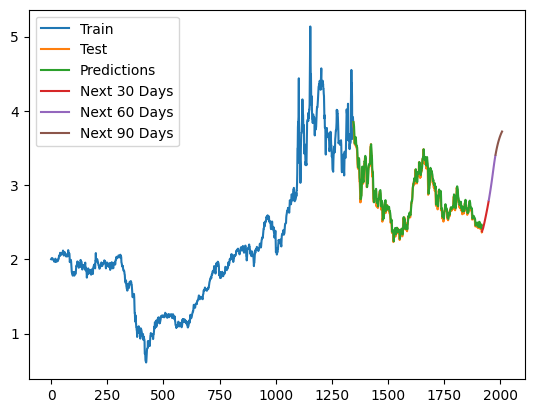

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (7:3)
train_size = int(0.7 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


# Train-Test 8:2

## Crude Oil - 8:2

Epoch 1/20
48/48 [==============================] - 2s 5ms/step - loss: 0.1739
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 3/20
48/48 [==============================] - 0s 6ms/step - loss: 8.5071e-04
Epoch 4/20
48/48 [==============================] - 0s 5ms/step - loss: 7.0035e-04
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 5.8071e-04
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 4.6450e-04
Epoch 7/20
48/48 [==============================] - 0s 5ms/step - loss: 3.5304e-04
Epoch 8/20
48/48 [==============================] - 0s 4ms/step - loss: 2.7482e-04
Epoch 9/20
48/48 [==============================] - 0s 8ms/step - loss: 2.3898e-04
Epoch 10/20
48/48 [==============================] - 0s 8ms/step - loss: 2.3448e-04
Epoch 11/20
48/48 [==============================] - 0s 8ms/step - loss: 2.2504e-04
Epoch 12/20
48/48 [==============================] - 0s 6ms/step - loss: 2.2048e-04
Epoch 13/

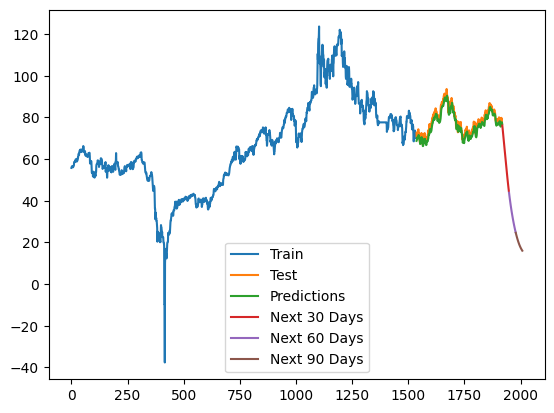

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil WTI.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Gasoline RBOB - 8:2

Epoch 1/20
48/48 [==============================] - 2s 6ms/step - loss: 0.0736
Epoch 2/20
48/48 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 3/20
48/48 [==============================] - 0s 7ms/step - loss: 3.7325e-04
Epoch 4/20
48/48 [==============================] - 0s 7ms/step - loss: 3.0920e-04
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 2.9112e-04
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 3.1449e-04
Epoch 7/20
48/48 [==============================] - 0s 4ms/step - loss: 3.0168e-04
Epoch 8/20
48/48 [==============================] - 0s 4ms/step - loss: 2.8739e-04
Epoch 9/20
48/48 [==============================] - 0s 5ms/step - loss: 2.7368e-04
Epoch 10/20
48/48 [==============================] - 0s 6ms/step - loss: 2.9503e-04
Epoch 11/20
48/48 [==============================] - 0s 4ms/step - loss: 2.8001e-04
Epoch 12/20
48/48 [==============================] - 0s 4ms/step - loss: 2.8332e-04
Epoch 13/

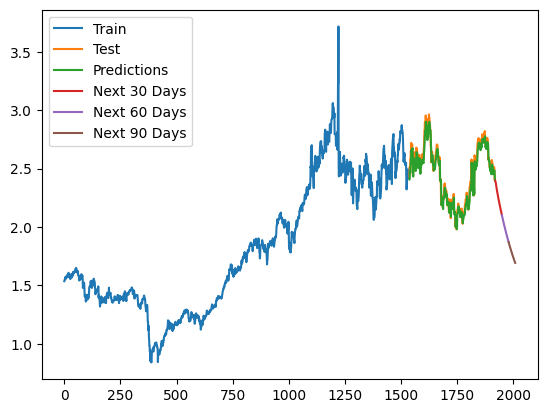

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Heating Oil - 8:2

Epoch 1/20
48/48 [==============================] - 1s 4ms/step - loss: 0.0291
Epoch 2/20
48/48 [==============================] - 0s 4ms/step - loss: 4.0738e-04
Epoch 3/20
48/48 [==============================] - 0s 4ms/step - loss: 3.6103e-04
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 3.4067e-04
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 3.2474e-04
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 3.1274e-04
Epoch 7/20
48/48 [==============================] - 0s 5ms/step - loss: 3.0846e-04
Epoch 8/20
48/48 [==============================] - 0s 5ms/step - loss: 3.2147e-04
Epoch 9/20
48/48 [==============================] - 0s 6ms/step - loss: 2.9546e-04
Epoch 10/20
48/48 [==============================] - 0s 6ms/step - loss: 3.1692e-04
Epoch 11/20
48/48 [==============================] - 0s 6ms/step - loss: 2.9415e-04
Epoch 12/20
48/48 [==============================] - 0s 7ms/step - loss: 2.8190e-04
Epoch

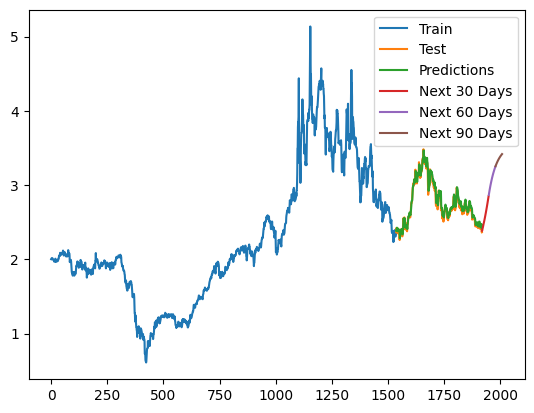

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (8:2)
train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


# Train-Test 9:1

## Crude Oil - 9:1

Epoch 1/20
54/54 [==============================] - 1s 4ms/step - loss: 0.0249
Epoch 2/20
54/54 [==============================] - 0s 7ms/step - loss: 3.6901e-04
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 3.1303e-04
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 2.7632e-04
Epoch 5/20
54/54 [==============================] - 0s 7ms/step - loss: 2.5381e-04
Epoch 6/20
54/54 [==============================] - 0s 7ms/step - loss: 2.3738e-04
Epoch 7/20
54/54 [==============================] - 0s 7ms/step - loss: 2.2515e-04
Epoch 8/20
54/54 [==============================] - 0s 7ms/step - loss: 2.2242e-04
Epoch 9/20
54/54 [==============================] - 0s 6ms/step - loss: 2.3218e-04
Epoch 10/20
54/54 [==============================] - 0s 8ms/step - loss: 2.3280e-04
Epoch 11/20
54/54 [==============================] - 0s 8ms/step - loss: 2.1935e-04
Epoch 12/20
54/54 [==============================] - 0s 7ms/step - loss: 2.1227e-04
Epoch

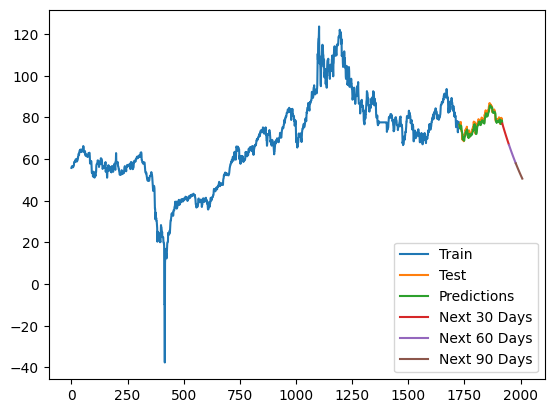

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Crude Oil WTI.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Gasoline RBOB - 9:1

Epoch 1/20
54/54 [==============================] - 1s 4ms/step - loss: 0.0211
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 3.4791e-04
Epoch 3/20
54/54 [==============================] - 0s 6ms/step - loss: 3.4196e-04
Epoch 4/20
54/54 [==============================] - 0s 6ms/step - loss: 3.2929e-04
Epoch 5/20
54/54 [==============================] - 0s 6ms/step - loss: 3.5086e-04
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 3.2397e-04
Epoch 7/20
54/54 [==============================] - 0s 6ms/step - loss: 3.2264e-04
Epoch 8/20
54/54 [==============================] - 0s 7ms/step - loss: 3.2494e-04
Epoch 9/20
54/54 [==============================] - 0s 9ms/step - loss: 3.1190e-04
Epoch 10/20
54/54 [==============================] - 0s 7ms/step - loss: 3.0620e-04
Epoch 11/20
54/54 [==============================] - 0s 6ms/step - loss: 3.1456e-04
Epoch 12/20
54/54 [==============================] - 0s 7ms/step - loss: 3.0806e-04
Epoch

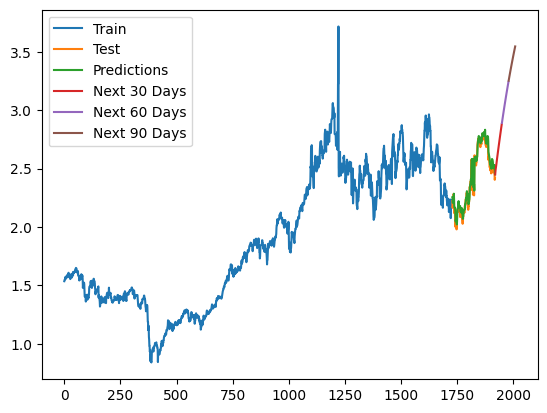

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Gasoline RBOB.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()


## Heating Oil - 9:1

Epoch 1/20
54/54 [==============================] - 2s 4ms/step - loss: 0.1462
Epoch 2/20
54/54 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 3/20
54/54 [==============================] - 0s 5ms/step - loss: 2.9245e-04
Epoch 4/20
54/54 [==============================] - 0s 5ms/step - loss: 2.6879e-04
Epoch 5/20
54/54 [==============================] - 0s 5ms/step - loss: 2.7960e-04
Epoch 6/20
54/54 [==============================] - 0s 5ms/step - loss: 2.6660e-04
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 3.2761e-04
Epoch 8/20
54/54 [==============================] - 0s 4ms/step - loss: 2.7591e-04
Epoch 9/20
54/54 [==============================] - 0s 4ms/step - loss: 2.7490e-04
Epoch 10/20
54/54 [==============================] - 0s 5ms/step - loss: 2.7134e-04
Epoch 11/20
54/54 [==============================] - 0s 4ms/step - loss: 3.0184e-04
Epoch 12/20
54/54 [==============================] - 0s 4ms/step - loss: 2.5679e-04
Epoch 13/

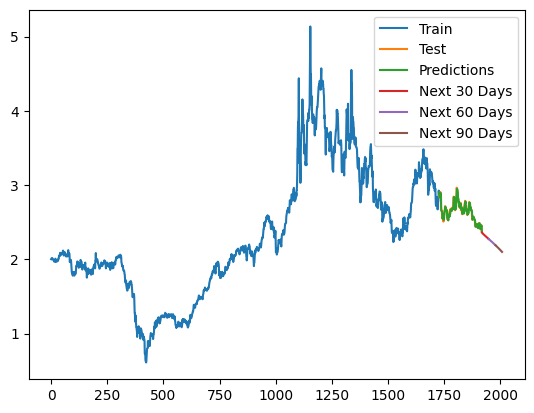

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

# Read the data file and remove missing lines
df = pd.read_csv('Heating Oil.csv')
df = df.dropna()

# Converting types of values
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return volume_str

def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)


# Create fake data for missing weekends
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Check if that date is in the data
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Check if DataFrame has data
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Calculate the average value of columns (except 'Date' column)
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Create a new Series with new dates and values
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Add a row of data to the new DataFrame
                weekend_data.loc[len(weekend_data)] = new_row

    # Combine original data and fake weekend data
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Apply the function to fill in values ​​for weekends
df = fill_missing_weekends(df)

df = df.dropna()
df = df.reset_index(drop=True)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

# Create sequences for Additive RNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
x, y = create_sequences(df['Price'], seq_length)

# Split dataset train-test (9:1)
train_size = int(0.9 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D for RNN (samples, timesteps, features)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build Additive RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32)

# Make predictions
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast for the next n days
def forecast_next_days(model, last_seq, n_days, scaler):
    forecast = []
    for _ in range(n_days):
        next_pred = model.predict(last_seq)
        forecast.append(next_pred[0, 0])
        last_seq = np.roll(last_seq, -1)
        last_seq[0, -1, 0] = next_pred[0, 0]
    forecast_inverse = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast_inverse

# Initial sequence for forecasting
last_seq = df['Price'][-seq_length:].values.reshape(1, seq_length, 1)

# Forecast for 30, 60, and 90 days
forecast_30_days = forecast_next_days(model, last_seq, 30, scaler)
forecast_60_days = forecast_next_days(model, last_seq, 60, scaler)
forecast_90_days = forecast_next_days(model, last_seq, 90, scaler)

# Evaluate the model based on error estimates and graphing
def evaluate(test, pred):
    print('- Calculate Error Values -')
    test_mae = mean_absolute_error(test, pred)
    print('MAE: ', test_mae)

    test_ape = np.abs((test - pred) / test)
    test_mape = np.mean(test_ape) * 100
    print('MAPE: ', test_mape, '%')

    test_mse = mean_squared_error(test, pred)
    test_rmse = np.sqrt(test_mse)
    print('RMSE: ', test_rmse)

evaluate(y_test_inverse, y_pred_inverse)

# Plot the results
plt.plot(df.index[:train_size+seq_length], scaler.inverse_transform(df['Price'][:train_size+seq_length].values.reshape(-1, 1)))
plt.plot(df.index[train_size+seq_length:], y_test_inverse)
plt.plot(df.index[train_size+seq_length:], y_pred_inverse)

plt.plot(range(len(df), len(df) + 30), forecast_30_days, label='Next 30 Days')
plt.plot(range(len(df) + 30, len(df) + 60), forecast_60_days[30:60], label='Next 60 Days')
plt.plot(range(len(df) + 60, len(df) + 90), forecast_90_days[60:], label='Next 90 Days')

plt.legend(['Train', 'Test', 'Predictions', 'Next 30 Days', 'Next 60 Days', 'Next 90 Days'])
plt.show()
